In [1]:
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm 
import glob
import torch.nn as nn
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import os

In [4]:
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
    
])

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32)):

  plt.figure(figsize=(8, 8))
  image_tensor = (image_tensor + 1) / 2 # between 0 and 1 
  image_tensor = image_tensor.cpu().detach()

  image_grid = make_grid(image_tensor[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        haze_class = models.densenet121(pretrained=True)

        ############# Block0-down  ##############
        self.conv0 = haze_class.features.conv0
        self.relu0 = haze_class.features.relu0
        self.pool0 = haze_class.features.pool0

        ############# Block1-down ##############
        self.dense_block1 = haze_class.features.denseblock1
        self.trans_block1 = haze_class.features.transition1

        ############# Block2-down ##############
        self.dense_block2 = haze_class.features.denseblock2
        self.trans_block2 = haze_class.features.transition2

        ############# Block3-down ##############
        self.dense_block3 = haze_class.features.denseblock3
        self.trans_block3 = haze_class.features.transition3
        self.res31 = BasicResBlock(512, 512)
        self.res32 = BasicResBlock(512, 512)

        ############# Block4-up ##############
        self.dense_block4 = BottleneckBlock(512, 256)
        self.trans_block4 = TransitionBlock(768, 128)
        self.res41 = BasicResBlock(387, 387)
        self.res42 = BasicResBlock(387, 387)

        ############# Block3-up ##############
        self.dense_block5 = BottleneckBlock(387, 256)
        self.trans_block5 = TransitionBlock(643, 128)
        self.res51 = BasicResBlock(259, 259)
        self.res52 = BasicResBlock(259, 259)

        ############# Block2-up ##############
        self.dense_block6 = BottleneckBlock(259, 128)
        self.trans_block6 = TransitionBlock(387, 64)
        self.res61 = BasicResBlock(67, 67)
        self.res62 = BasicResBlock(67, 67)

        ############# Block1-up ##############
        self.dense_block7 = BottleneckBlock(67, 64)
        self.trans_block7 = TransitionBlock(131, 32)
        self.res71 = BasicResBlock(35, 35)
        self.res72 = BasicResBlock(35, 35)

        ############# Block0-up ##############
        self.dense_block8 = BottleneckBlock(35, 32)
        self.trans_block8 = TransitionBlock(67, 16)

        # multi-scale
        self.conv_refin = nn.Conv2d(19, 20, 3, 1, 1)
        self.refout = nn.Conv2d(20, 3, kernel_size=3, stride=1, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        ## input: 1024 x 1024

        x0 = self.pool0(self.relu0(self.conv0(x)))  # 256 x 256

        x1 = self.dense_block1(x0)  # 256 x 256

        x1 = self.trans_block1(x1)  # 128 x 128

        x2 = self.trans_block2(self.dense_block2(x1))  # 64 x 64

        x3 = self.trans_block3(self.dense_block3(x2))  # 32 x 32
        x3 = self.res31(x3)  # 32 x 32
        x3 = self.res32(x3)  # 32 x 32

        x4 = self.trans_block4(self.dense_block4(x3))  # 64 x 64
        x43 = F.avg_pool2d(x, 16)  # 64 x 64
        x42 = torch.cat([x4, x2, x43], 1)  # 64 x 64
        x42 = self.res41(x42)  # 64
        x42 = self.res42(x42)  # 64

        x5 = self.trans_block5(self.dense_block5(x42))  # 128
        x53 = F.avg_pool2d(x, 8)  # 128
        x52 = torch.cat([x5, x1, x53], 1)  # 128
        x52 = self.res51(x52)  # 128
        x52 = self.res52(x52)  # 128

        x6 = self.trans_block6(self.dense_block6(x52))  # 256
        x63 = F.avg_pool2d(x, 4)  # 256
        x62 = torch.cat([x6, x63], 1)  # 256
        x62 = self.res61(x62)  # 256
        x6 = self.res62(x62)  # 256

        x7 = self.trans_block7(self.dense_block7(x6))  # 512
        x73 = F.avg_pool2d(x, 2)  # 512
        x72 = torch.cat([x7, x73], 1)  # 512
        x72 = self.res71(x72)  # 512
        x7 = self.res72(x72)  # 512

        x8 = self.trans_block8(self.dense_block8(x7))  # 1024
        x8 = torch.cat([x8, x], 1)  # 1024

        x9 = self.relu(self.conv_refin(x8))  # 1024

        dehaze = self.tanh(self.refout(x9))

        return dehaze


class BottleneckBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(BottleneckBlock, self).__init__()
        inter_planes = out_planes * 4
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_planes, inter_planes, kernel_size=1, stride=1,
                               padding=0, bias=False)
        self.conv2 = nn.Conv2d(inter_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu(x))
        out = self.conv2(self.relu(out))
        return torch.cat([x, out], 1)


class TransitionBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(TransitionBlock, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.ConvTranspose2d(in_planes, out_planes, kernel_size=1, stride=1,
                                        padding=0, bias=False)

    def forward(self, x):
        out = self.conv1(self.relu(x))
        return F.interpolate(out, scale_factor=2)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicResBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(BasicResBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        out += residual
        out = self.relu(out)

        return out


class Discriminator(nn.Module):
    def __init__(self, nc=3, nf=36):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(nc, nf, kernel_size=4, stride=2, padding=1, bias=False),  # 36 x 512 x 512
            nn.LeakyReLU(0.2, inplace=True),
            DBlock(nf, nf * 2),  # 72 x 256 x 256
            DBlock(nf * 2, nf * 4),  # 144 x 128 x 128
            DBlock(nf * 4, nf * 8),  # 288 x 64 x 64
            DBlock(nf * 8, nf * 8),  # 288 x 32 x 632
            nn.Conv2d(nf * 8, nf * 8, 4, 1, 1, bias=False),  # 288 x 31 x 31
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(nf * 8, 1, 4, 1, 1, bias=False),  # 288 x 30 x 30
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.main(x)
        return output

    def requires_grad(self, req):
        for param in self.parameters():
            param.requires_grad = req


class DBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        output = self.main(x)
        return output

In [6]:
ckpt = torch.load("/content/drive/MyDrive/dehazing_checkpoints/new_ckpt_epoch_2_iter_20.pth")
gen = Generator()
gen.load_state_dict(ckpt["generator_state_dict"])

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [18]:
img = Image.open("/content/drive/MyDrive/Haze dataset/Haze/275.jpg")
img = transform(img)

img.shape

torch.Size([3, 1024, 1024])

In [19]:
out = gen(img.unsqueeze(dim=0))
out.shape

torch.Size([1, 3, 1024, 1024])

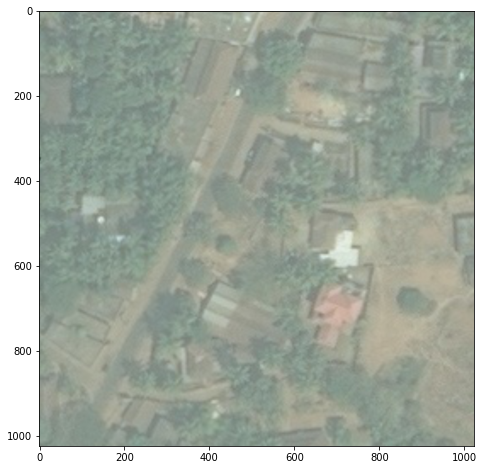

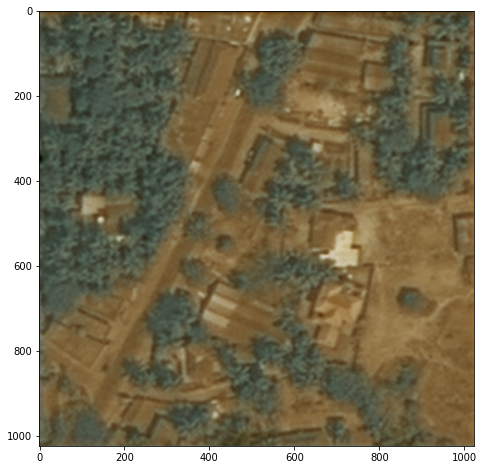

In [20]:
show_tensor_images(img)
show_tensor_images(out)